In [2]:
import sys
sys.path.append('../../')
sys.path.append('../')

In [3]:
dataset_path = "../../dataset"
preprocessed_dataset_path = "preprocessed_dataset"

In [4]:
from codes.docs.analysis import data_preprocessing
from codes.docs.analysis.gene_analysis import genetic_file_preprocess

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io
import glob
from collections import defaultdict
%matplotlib inline

Notebook 1 description: 
1. Imaging data is imported and preprocessed

Available informations
- Volumetric dataset (dHCP) - 675 individuals
- Diffusion dataset - 432 individuals
- Microstructure - 318 individuals
- Cortical thickness - 234 individuals
2. Genetic data is added and outliers removed
- Schizophrenia - PRS calculated from GWAS 2020 (Ripke et al., 2020)

# 1. Data Preprocessing and Importing

## Importing volumetric, diffusion, microstructural, cortical thickness dataset

### Volumetric dataset

The `full_dataset` contains all the volumetric information for the full cohort. Labels are saved in `Imperial_label` and `AAL_label`

In [5]:
#Volumetric dataset
full_dataset = pd.read_excel(open(
    dataset_path +
    '/volumetric/full_dataset/allSubjectsWithKANA_AALVolumes_mm3_4Harriet_withCovariates_withImperialLegendsOK.xlsx',
    'rb'),
                             sheet_name='allSubjectsWithKANA_AALVolumes').drop(
                                 'ID', axis=1)
full_dataset = full_dataset.rename({'Subject': 'ID'}, axis=1)
full_dataset.rename(columns={
    'GA at birth': 'GA',
    'PMA at birth': 'PMA'
},
                    inplace=True)
full_dataset = full_dataset.sort_values(by='Session', ascending=False)
full_dataset = full_dataset.drop_duplicates(subset='ID', keep='last')
full_dataset = full_dataset.reset_index(drop=True)

In [8]:
Imperial_label = pd.read_excel(open(
    f'{dataset_path}/volumetric/full_dataset/allSubjectsWithKANA_AALVolumes_mm3_4Harriet_withCovariates_withImperialLegendsOK.xlsx',
    'rb'),
                               sheet_name='IMPERIAL ROIs LEGEND',
                               header=None).drop([0, 1], axis=1)
AAL_label = pd.read_excel(open(
    f'{dataset_path}/volumetric/full_dataset/allSubjectsWithKANA_AALVolumes_mm3_4Harriet_withCovariates_withImperialLegendsOK.xlsx',
    'rb'),
                          sheet_name='AAL LEGEND',
                          header=None).drop(0, axis=1)

from string import digits

AAL_label = np.asarray(
    [str.split(i, ' ')[1] for i in np.asarray(AAL_label).reshape(-1)])
Imperial_label = np.asarray([
    str.strip(i.translate({ord(c): None
                           for c in digits}))
    for i in (np.asarray(Imperial_label)).reshape(-1)
])

In [9]:
print('volumetric dataset')
full_dataset.shape

volumetric dataset


(675, 204)

In [11]:
full_dataset.to_csv(f'{preprocessed_dataset_path}/imaging_data/log_file/full_dataset.csv',index=False)

### Diffusion dataset

The diffusion dataset is saved in the matlab file. 
It is saved in the `diffusion_full_dataset`

The labels are saved in the `ROIs_combinations`

In [13]:
ROIs_combinations = data_preprocessing.Diffusion.create_ROIs_combinations(
    f'{dataset_path}/diff_dataset/Regions_of_interests.csv')

In [14]:
#Diffusion dataset
diffusion_full_dataset = scipy.io.loadmat(
    f'{dataset_path}/diff_dataset/2020_04_MASTER_connectomes90_433subj_SCandFC_TermScansVolOK.mat'
)
diffusion_matrices = diffusion_full_dataset[
    'SCmu']  #use the Structural Connectivity (SIFT2-weighted * Mu) [equivalent to raw connectivity, see SIFT2 paper]
diffusion_matrices = [
    diffusion_matrices[:, :, i] for i in range(diffusion_matrices.shape[2])
]  # rearranged them into (433,90,90)
diffusion_matrices = np.asarray(diffusion_matrices)

In [15]:
diffusion_matrices = np.asarray([
    data_preprocessing.Diffusion.lower_triangle(diffusion_matrices[i])
    for i in range(diffusion_matrices.shape[0])
])
diffusion_matrices = pd.DataFrame(diffusion_matrices)

In [16]:
diffusion_matrices.columns = data_preprocessing.Diffusion.lower_triangle(
    ROIs_combinations)

In [17]:
diffusion_subject_id = diffusion_full_dataset['sub'].reshape(-1, 1)
diffusion_subject_id = [
    i[0][0].replace('sub-', '') for i in diffusion_subject_id
]
diffusion_subject_sess = diffusion_full_dataset['ses'].reshape(-1, 1)
diffusion_subject_sess = [
    i[0][0].replace('ses-', '') for i in diffusion_subject_sess
]
diffusion_subject_pma = diffusion_full_dataset['pma'].reshape(-1)
diffusion_subject_ga = diffusion_full_dataset['ga'].reshape(-1)

diffusion_dataset = pd.DataFrame({
    'ID': diffusion_subject_id,
    'Session': diffusion_subject_sess,
    'GA': diffusion_subject_ga,
    'PMA': diffusion_subject_pma
})

# diffusion_dataset['Gender'] = diffusion_full_dataset['sex'].reshape(-1)

#match the ID to the diffusion matrices
diffusion_dataset = pd.concat((diffusion_dataset, diffusion_matrices), axis=1)
#rearrange by the session, drop the duplicates and keep the last session
diffusion_dataset = diffusion_dataset.sort_values(by='Session',
                                                  ascending=False)
diffusion_dataset = diffusion_dataset.drop_duplicates(subset='ID', keep='last')
diffusion_dataset = diffusion_dataset.reset_index(drop=True)

In [12]:
print('diffusion dataset')
diffusion_dataset.shape

diffusion dataset


(432, 4009)

In [18]:
diffusion_dataset.to_csv(
    f'{preprocessed_dataset_path}/imaging_data/log_file/diffusion_dataset.csv',
    index=False)

### microstructure dataset

microstructure data contains `FA`, `MD`, etc. 

In [19]:
#microstructure dataset
microstructure_file_path = f'{dataset_path}/microstructure/052021/'
dHCP_microstructure_info = pd.read_excel(
    microstructure_file_path +
    'dHCP-info-for-H_outcomes_and_rad_scores_05_2021.xlsx')
dHCP_microstructure_info = dHCP_microstructure_info[[
    'ID', 'potential registration artefacts', 'GA at birth', 'GA at scan ',
    'Birth weight', 'Head circumference at scan', 'dmri', 't2ms'
]]
dHCP_microstructure_info.columns = [
    'ID', 'potential registration artefacts', 'GA_micro', 'PMA_micro',
    'Birth weight', 'Head circumference at scan', 'dmri', 't2ms'
]

In [20]:
# Importing the microstructure files
micro_dict_europeans_df = defaultdict(pd.DataFrame)
for file in glob.glob(microstructure_file_path +
                      '/europeans/*-wm-*-stats*.csv'):
    micro = str.split(file, '-')[-3]
    micro_dict_europeans_df[micro] = pd.read_csv(file).dropna(how='any',
                                                              axis=1)
    micro_dict_europeans_df[micro].columns = [
        i + str.upper('_' + micro) if i != 'id' else 'ID'
        for i in micro_dict_europeans_df[micro].columns
    ]  # adding the microstructure name to each of the feature
    micro_dict_europeans_df[micro]['ID'] = [
        i.split('-')[2].split('_')[0]
        for i in micro_dict_europeans_df[micro]['ID']
    ]  # change the ID format

# Adding the microstructure files together into one table.
from functools import reduce

dHCP_microstructure_europeans = reduce(
    lambda left, right: pd.merge(left, right, on='ID', how='outer'), [
        micro_dict_europeans_df['fa'], micro_dict_europeans_df['md'],
        micro_dict_europeans_df['t12'], micro_dict_europeans_df['t2'],
        micro_dict_europeans_df['fiso']
    ])

In [21]:
#### adding asians microstructure files
micro_dict_asians_df = defaultdict(pd.DataFrame)
for file in glob.glob(microstructure_file_path + '/asians/*-wm-*-stats*.csv'):
    micro = str.split(file, '-')[-3]
    micro_dict_asians_df[micro] = pd.read_csv(file).dropna(how='any', axis=1)
    micro_dict_asians_df[micro].columns = [
        i + str.upper('_' + micro) if i != 'id' else 'ID'
        for i in micro_dict_asians_df[micro].columns
    ]  # adding the microstructure name to each of the feature
    micro_dict_asians_df[micro]['ID'] = [
        i.split('-')[2].split('_')[0]
        for i in micro_dict_asians_df[micro]['ID']
    ]  # change the ID format

from functools import reduce

dHCP_microstructure_asians = reduce(
    lambda left, right: pd.merge(left, right, on='ID', how='outer'), [
        micro_dict_asians_df['fa'], micro_dict_asians_df['md'],
        micro_dict_asians_df['t12'], micro_dict_asians_df['t2'],
        micro_dict_asians_df['fiso']
    ])

In [22]:
dHCP_microstructure = pd.concat(
    [dHCP_microstructure_europeans,
     dHCP_microstructure_asians]).reset_index(drop=True)

#merge the information with the available data

dHCP_microstructure_info = dHCP_microstructure.merge(dHCP_microstructure_info,
                                                     on='ID',
                                                     how='outer')

In [23]:
not_usable_subj_micro = dHCP_microstructure_info[(
    dHCP_microstructure_info['potential registration artefacts'].notna()
)]  #removed anything that has not OK dmri or t2ms or potential registration artefacts

dHCP_microstructure_info = dHCP_microstructure_info.drop(
    index=not_usable_subj_micro.index).reset_index(drop=True).drop(
        labels=['potential registration artefacts', 'dmri', 't2ms'], axis=1)

In [24]:
print('microstructure info')
dHCP_microstructure_info.shape

microstructure info


(318, 275)

In [25]:
dHCP_microstructure_info.to_csv(f'{preprocessed_dataset_path}/imaging_data/log_file/dHCP_microstructure_info.csv',index=False)

### Cortical Thickness dataset

`cortical_thickness_df` contains the mean cortical thickness information.

In [26]:
cortical_thickness_df = pd.read_csv('./dataset/cortical_thickness/cortical_thickness_updated.csv')
cortical_thickness_df['Session_cortical'] = cortical_thickness_df['session']
cortical_thickness_df.drop('session', axis=1, inplace=True)

In [20]:
cortical_thickness_df.shape

(234, 3)

In [27]:
cortical_thickness_df.to_csv(f'{preprocessed_dataset_path}/imaging_data/log_file/cortical_thickness_df.csv',index=False)

## Merging all data with PRS scores

- PRS file contains PRS at 11 P-value thresholds, which ranges from 1e-8 to 1.
- The Ancestry files contains the first 10 PCs of the genetic data
- The data can be divided into 3 different ethnic groups: European, South Asian and African
- The outliers are removed to each cohort separately (i.e., European, European + South Asian (called mixed cohort), and European + South Asian + Africans (called full cohort)

In [19]:
full_dataset = pd.read_csv(f'{preprocessed_dataset_path}/imaging_data/log_file/full_dataset.csv')
cortical_thickness_df = pd.read_csv(f'{preprocessed_dataset_path}/imaging_data/log_file/cortical_thickness_df.csv')
diffusion_dataset = pd.read_csv(f'{preprocessed_dataset_path}/imaging_data/log_file/diffusion_dataset.csv')
dHCP_microstructure_info = pd.read_csv(f'{preprocessed_dataset_path}/imaging_data/log_file/dHCP_microstructure_info.csv')

In [21]:
#Merge the diffusion with structural data together
full_dataset = full_dataset.merge(diffusion_dataset,
                                  on='ID',
                                  suffixes=('_vol', '_diff'),
                                  how='outer')  #merging the diffusion dataset
full_dataset = full_dataset.merge(
    dHCP_microstructure_info, on='ID',
    how='outer')  # merging the microstructure dataset

full_dataset = full_dataset.merge(cortical_thickness_df, on='ID',
                                  how='outer')  # merging the cortical dataset

dHCP_participants_info = pd.read_csv(
    f'{dataset_path}/participant_info/dHCP Neonatal Data Release 3 subjects - Participant info & reconstruction.csv'
)
dHCP_participants_info = dHCP_participants_info[[
    'ID', 'Gender', 'GA at birth', 'GA at scan ','Birth weight'
]]
dHCP_participants_info = dHCP_participants_info.rename(
    {
        'GA at birth': 'GA_full',
        'GA at scan ': 'PMA_full',
        'Birth weight': 'Birth weight full'
    }, axis=1)
dHCP_participants_info = dHCP_participants_info.drop_duplicates(subset='ID',
                                                                keep='last')
full_dataset = full_dataset.merge(dHCP_participants_info, on='ID',
                                  how='left')  #added gender info

####### Given that the GA and PMA information is likely to come from the full dataset, I will just define the missing GA_micro and PMA micro information to the GA_full and PMA_full (from the full dataset)
full_dataset['GA_micro'] = full_dataset['GA_full']
full_dataset['PMA_micro'] = full_dataset['PMA_full']
full_dataset['Birth weight'] = full_dataset['Birth weight full']

In [22]:
full_dataset.to_csv(f'{preprocessed_dataset_path}/imaging_data/log_file/combined_imaging_full_dataset.csv',index=False)

In [23]:
full_dataset = pd.read_csv(f'{preprocessed_dataset_path}/imaging_data/log_file/combined_imaging_full_dataset.csv',index_col=[0])

In [24]:
pheno = 'scz'
european_cohort = genetic_file_preprocess.Cohort(
    cohort_name='euro',
    PRS_file_path=
    f'{dataset_path}/PRS/{pheno}/SCZ3_lifted37_dHCP_merged_cleaned_EUROPEANS_updated.gwas.all.score',
    Ancestry_file_path=
    f'{dataset_path}/ancestry_PCs/file3_only_europ_10pcs_pca.eigenvec',
    imaging_df=full_dataset)
mixed_cohort = genetic_file_preprocess.Cohort(
    cohort_name='mixed',
    PRS_file_path=
    f'{dataset_path}/PRS/{pheno}/SCZ3_lifted37_dHCP_merged_cleaned_EUROPEANS_ASIAN_361.gwas.all.score',
    Ancestry_file_path=
    f'{dataset_path}/ancestry_PCs/euro_asian_361_file3_pca.eigenvec',
    imaging_df=full_dataset)
full_cohort = genetic_file_preprocess.Cohort(
    cohort_name='full',
    PRS_file_path=
    f'{dataset_path}/PRS/{pheno}/SCZ3_lifted37_dHCP_merged_cleaned_ALL_562.gwas.all.score',
    Ancestry_file_path=f'{dataset_path}/ancestry_PCs/file3_all_pca.eigenvec',
    imaging_df=full_dataset)

In [25]:
#european_ID and asian_ID
european_ID = european_cohort.cohort_data.index.tolist()
asian_ID = [
    i for i in mixed_cohort.cohort_data.index.tolist()
    if i not in european_ID
]
african_ID = [
    i for i in full_cohort.cohort_data.index.tolist()
    if (i not in european_ID) and (i not in asian_ID)
]
cohort_list = pd.DataFrame({'ID':full_cohort.cohort_data.index.tolist(),
             'cohort':['EUR' if i in european_ID else 'ASI' if i in asian_ID else 'AFR' for i in full_cohort.cohort_data.index.tolist()]})
cohort_list = cohort_list.set_index('ID')

european_cohort.append_cohort_list(cohort_list)
mixed_cohort.append_cohort_list(cohort_list)
full_cohort.append_cohort_list(cohort_list)

### saving full dataset

In [26]:
pd.pivot_table(full_cohort.cohort_data,
               values=['GA_vol','PMA_vol'],
               index=['cohort','termness'],
               aggfunc={'cohort':np.count_nonzero,
                        'GA_vol':np.mean,
                        'PMA_vol':np.mean})

GA_vol    PMA_vol  cohort
cohort termness                                          
AFR    preterm               33.297619  35.238095      12
       preterm/term_at_scan  30.066327  35.581633      28
       term                  39.887955  40.791783     153
ASI    preterm               32.214286  34.142857       2
       preterm/term_at_scan  33.321429  35.446429       8
       term                  39.982456  41.127820      57
EUR    preterm               32.857143  34.610390      13
       preterm/term_at_scan  31.849351  36.688312      56
       term                  40.079515  41.522237     219

In [27]:
full_cohort.cohort_data.to_csv(f'{preprocessed_dataset_path}/imaging_data/log_file/combined_imaging_genetic_pre_outliers_full_dataset.csv')

In [11]:
# full_dataset.drop(columns=['Session_vol','Session_diff'],inplace=True)
# full_dataset = data_preprocessing.move_multiple_columns(full_dataset,cols_to_move=['Gender','GA_diff','PMA_diff'],ref_col='ID',place='After')

### Removing outliers

Outlier is defined using the Anc PCs. Should I do the this for each dataset or all of them together? Note that the ancestry components for european cohort alone is different from ancestry PCs for european from european and asian cohort mixed

In [28]:
european_cohort.extract_neonates_data(termness = 'term') # other options = preterm/term_at_scan
mixed_cohort.extract_neonates_data(termness = 'term')
full_cohort.extract_neonates_data(termness = 'term')

In [29]:
print('available number of subjects in each dataset before removing outliers')
pd.DataFrame({
    'Dataset': ['Vol', 'Diff', 'Micro'],
    'euro_number': [
        european_cohort.volumetric_df.shape[0],
        european_cohort.diffusion_df.shape[0],
        european_cohort.micro_df.shape[0]
    ],
    'mixed_number': [
        mixed_cohort.volumetric_df.shape[0],
        mixed_cohort.diffusion_df.shape[0],
        mixed_cohort.micro_df.shape[0]
    ],
    'full_number': [
        full_cohort.volumetric_df.shape[0],
        full_cohort.diffusion_df.shape[0],
        full_cohort.micro_df.shape[0]
    ]
})

available number of subjects in each dataset before removing outliers


,Dataset,euro_number,mixed_number,full_number
0,Vol,212,269,422
1,Diff,159,195,304
2,Micro,163,194,194


Outliers are defined if they have more than 3.5 standard deviation on the AncPC2 and AncPC3

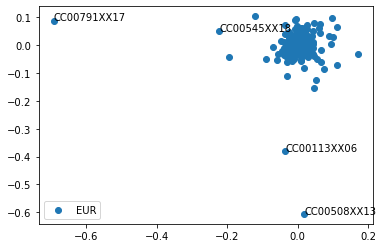

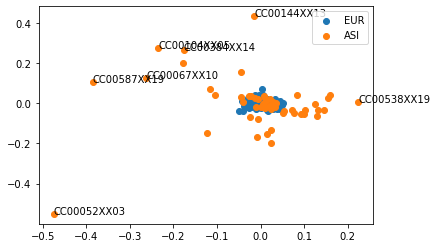

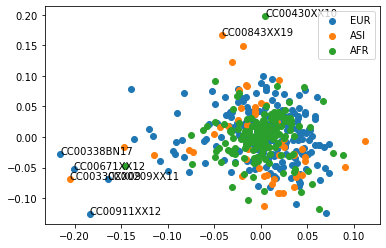

In [30]:
european_cohort.volumetric_df,_ = genetic_file_preprocess.Cohort.remove_outliers(european_cohort.volumetric_df,
                                                     ancestry_PCs=['euro_Anc_PC2','euro_Anc_PC3'])
mixed_cohort.volumetric_df,_ = genetic_file_preprocess.Cohort.remove_outliers(mixed_cohort.volumetric_df,
                                                     ancestry_PCs=['mixed_Anc_PC4','mixed_Anc_PC5'])
full_cohort.volumetric_df,_ = genetic_file_preprocess.Cohort.remove_outliers(full_cohort.volumetric_df,
                                                     ancestry_PCs=['full_Anc_PC7','full_Anc_PC8'])

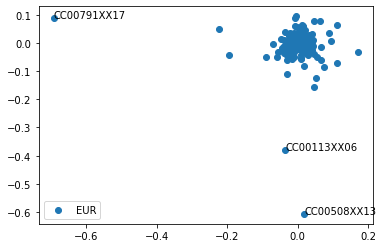

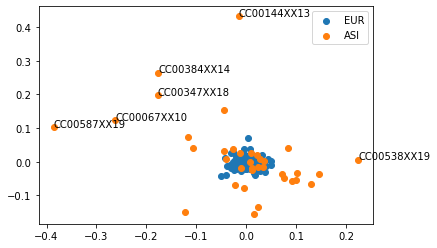

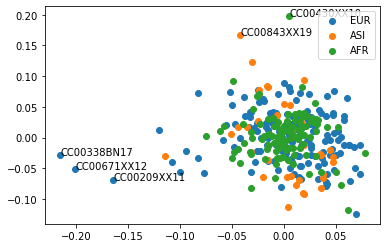

In [31]:
european_cohort.diffusion_df, _ = genetic_file_preprocess.Cohort.remove_outliers(european_cohort.diffusion_df,
                                            ancestry_PCs=['euro_Anc_PC2','euro_Anc_PC3'])
mixed_cohort.diffusion_df, _ = genetic_file_preprocess.Cohort.remove_outliers(mixed_cohort.diffusion_df,
                                                     ancestry_PCs=['mixed_Anc_PC4','mixed_Anc_PC5'])
full_cohort.diffusion_df, _ = genetic_file_preprocess.Cohort.remove_outliers(full_cohort.diffusion_df,
                                                     ancestry_PCs=['full_Anc_PC7','full_Anc_PC8'])

### saving preprocessed data without outliers

In [15]:
european_cohort.diffusion_df.to_csv(f'{preprocessed_dataset_path}/imaging_data/diffusion/term/european_diffusion_df.csv')
mixed_cohort.diffusion_df.to_csv(f'{preprocessed_dataset_path}/imaging_data/diffusion/term/mixed_diffusion_df.csv')
# full_cohort.diffusion_df.to_csv(f'{preprocessed_dataset_path}/imaging_data/diffusion/term/full_diffusion_df.csv')

# european_volumetric_term_dataset.to_csv('./preprocessed_data/volumetric/term/european_volumetric_term_dataset.csv',index=False)
# european_microstructure_term_dataset.to_csv('./preprocessed_data/microstructure/term/european_microstructure_term_dataset.csv',index=False)


# mixed_diffusion_term_dataset.to_csv('./preprocessed_data/diffusion/term/mixed_diffusion_term_dataset.csv',index=False)
# mixed_volumetric_term_dataset.to_csv('./preprocessed_data/volumetric/term/mixed_volumetric_term_dataset.csv',index=False)
# mixed_microstructure_term_dataset.to_csv('./preprocessed_data/microstructure/term/mixed_microstructure_term_dataset.csv',index=False)

# full_cohort_diffusion_term_dataset.to_csv('./preprocessed_data/diffusion/term/full_cohort_diffusion_term_dataset.csv',index=False)
# full_cohort_volumetric_term_dataset.to_csv('./preprocessed_data/volumetric/term/full_cohort_volumetric_term_dataset.csv',index=False)
# full_cohort_microstructure_term_dataset.to_csv('./preprocessed_data/microstructure/term/full_cohort_microstructure_term_dataset.csv',index=False)


In [34]:
european_cohort.volumetric_df.to_csv(f'{preprocessed_dataset_path}/imaging_data/volumetric/term/european_volumetric_df.csv')

mixed_cohort.volumetric_df.to_csv(f'{preprocessed_dataset_path}/imaging_data/volumetric/term/mixed_volumetric_df.csv')

full_cohort.volumetric_df.to_csv(f'{preprocessed_dataset_path}/imaging_data/volumetric/term/full_volumetric_df.csv')